In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np
import scipy

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.vis import plot, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
 - 6 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [4]:
data_bz = data["b2dz"]
data_bx = data["b2dx"]
data_by = data["b2dy"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 41.6

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [5]:
print(data_bz.min(), data_bz.max())

-3081.8796 3227.2979


In [6]:
folder = "/Users/lilli/Desktop/Thesis/ISSI_RMHD"

In [7]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [8]:
from mhsflex.field2d import check_fluxbalance, alpha_HS04

In [9]:
check_fluxbalance(data2d)
# So dont have to use Seeahafer

-0.0071758144

In [10]:
alpha_HS04(data_bx, data_by, data_bz)

0.010229302

In [11]:
import mhsflex.fluxbalance

In [12]:
alpha = alpha_HS04(data_bx, data_by, data_bz)

length_scale_x = nresol_x * pixelsize_x_Mm
length_scale_y = nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x
length_scale_y_norm = length_scale_y

kx_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * 2.0 * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi * 2.0 / length_scale_x_norm) ** 2 + (
    np.pi * 2.0 / length_scale_y_norm
) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

amax = limit.min()

print(amax, alpha)

0.4871930823404452 0.010229302


In [13]:
a = 0.48
alpha = 0.01

In [ ]:
data3d = mhsflex.fluxbalance.calculate_magfield(data2d, a, 1.0, alpha, z0, deltaz)

In [19]:
data3d.save(folder)

In [14]:
data3d = mhsflex.fluxbalance.Field3dData.load(folder + "/field")

In [15]:
path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

print(data3dref["info_unit"])
print(data3dref["info_pixel"])
print(data3dref["info_array"])

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

pres_3d = data3dref["p3d"] # * 10**-1
den_3d = data3dref["d3d"] #* 10**3

bx_rec = data3d.field[:,:, :, 1]
by_rec = data3d.field[:,:, :, 0]
bz_rec = data3d.field[:,:, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_ref = np.zeros((nresol_y, nresol_x, nresol_z, 3))

B_ref[:, :, :, 0] = issi_by[:,:,:]
B_ref[:, :, :, 1] = issi_bx[:,:,:]
B_ref[:, :, :, 2] = issi_bz[:,:,:]

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type NOTICE
 - 1 are of type VERSION
 - 8 are of type VARIABLE
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, d3d, p3d: magnetic vector (Gauss), plasma density (g/cm^3), plasma pressure (dyn/cm^2)'
b'Pixel spacing: 192km*192km*64km'
b'Array example: d3d(nx,ny,nz)'
(256, 512, 650)
(256, 512, 650

In [16]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy


In [53]:
from mhsflex.metrics import CauSchw_z, NormErr_z, MeanErr_z

In [17]:
print(VecCorr(B_ref, data3d.field))
print(CauSchw(B_ref, data3d.field))
print(NormErr(B_ref, data3d.field))
print(MeanErr(B_ref, data3d.field))
print(MagEnergy(B_ref, data3d.field))

0.9043088977775497
0.9408926803381343
0.30757626379371017
0.31484631939635116
0.8355335542071467


In [24]:
VCarr = np.zeros_like(z_arr)
CSarr = np.zeros_like(z_arr)
NEarr = np.zeros_like(z_arr)
MEarr = np.zeros_like(z_arr)
MgEnarr = np.zeros_like(z_arr)

In [54]:
for iz in range(nresol_z):

    VCarr[iz] = VecCorr(B_ref[:, :, iz, :], data3d.field[:, :, iz, :])
    CSarr[iz] = CauSchw_z(B_ref[:, :, iz, :], data3d.field[:, :, iz, :])
    NEarr[iz] = 1-NormErr_z(B_ref[:, :, iz, :], data3d.field[:, :, iz, :])
    MEarr[iz] = 1-MeanErr_z(B_ref[:, :, iz, :], data3d.field[:, :, iz, :])
    MgEnarr[iz] = MagEnergy(B_ref[:, :, iz, :], data3d.field[:, :, iz, :])


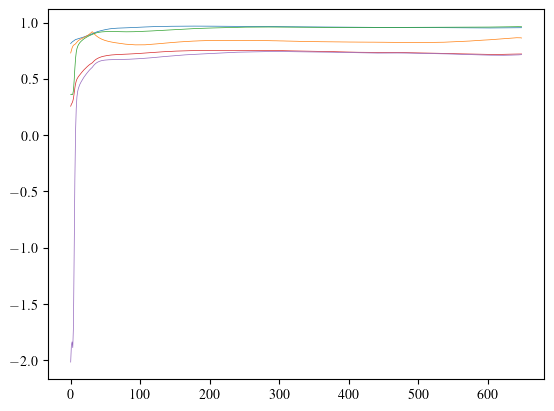

In [55]:
plt.plot(VCarr, linewidth=0.5)
plt.plot(MgEnarr, linewidth=0.5)
plt.plot(CSarr, linewidth=0.5)
plt.plot(NEarr, linewidth=0.5)
plt.plot(MEarr, linewidth=0.5)
#plt.ylim([0.8, 1])

In [56]:
temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

from mhsflex.fluxbalance import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

backtemp = btemp_linear(data3d, heights, temps)
backpres = bpressure_linear(data3d, heights, temps)
backden = bdensity_linear(data3d, heights, temps)

In [57]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 2.0 * 10.0**6  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)
RHO0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)

P0 = T_PHOTOSPHERE * KB * RHO0 / MBAR  # plasma pressure in kg/(s^2 m)
MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data3d.bz.max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
BETA0 = P0 / PB0  # Plasma Beta, ration plasma to magnetic pressure

In [58]:
c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7332/4189627657.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


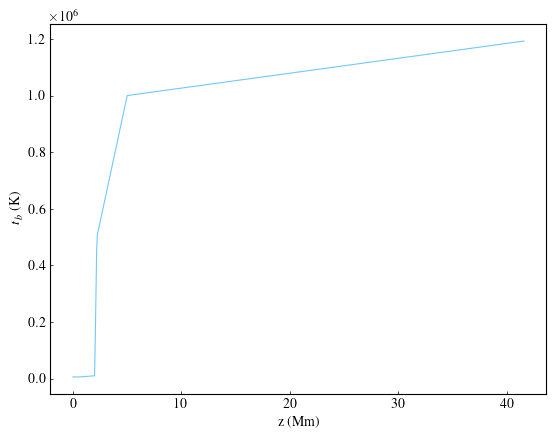

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7332/4189627657.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


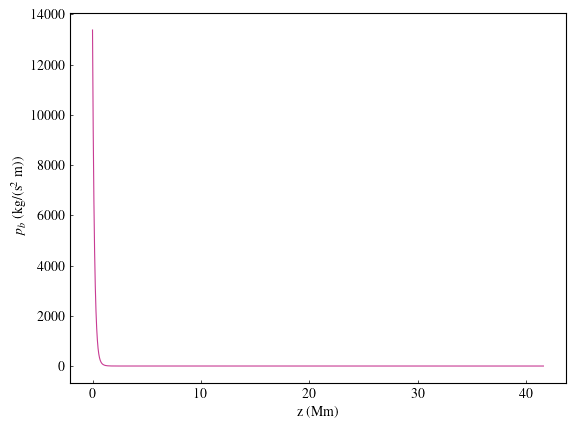

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7332/4189627657.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


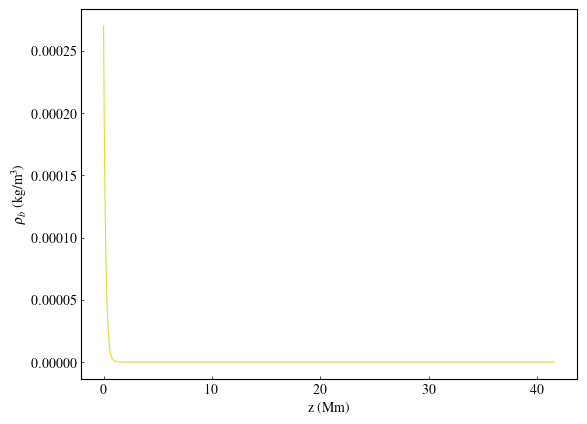

In [59]:
plt.plot(
    z_arr,
    backtemp,
    linewidth=0.8,
    color=c1,
)
#plt.ylabel(r"kg/($\textrm{s}^2$ m)")
plt.ylabel(r"$t_b$ (K)")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/btemp.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.8,
    color=c5,
)
plt.ylabel(r"$p_b$ (kg/($\textrm{s}^2$ m))")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/bpres.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

plt.plot(
    z_arr,
    BETA0 / (2.0 * H) * T0 / T_PHOTOSPHERE * backden * (B0 * 10**-4) ** 2.0 / (MU0 * G_SOLAR * L),
    linewidth=0.8,
    color=c8,
)
plt.ylabel(r"$\rho_b$ (kg/$\textrm{m}^3$)")
plt.xlabel("z (Mm)")
plt.legend(frameon=False)
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/bden.png"
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [60]:
maxcoord = np.unravel_index(
    np.argmax(data3d.bz, axis=None),
    data3d.bz.shape,
)
iy = int(maxcoord[0])
ix = int(maxcoord[1])

fpres = fpressure_linear(data3d, heights, temps)
fden = fdensity_linear(data3d, heights, temps)

In [61]:
fpresISSI = np.zeros_like(fpres)
fdenISSI = np.zeros_like(fden)

In [62]:
for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            fpresISSI[i, j, k] = pres_3d[k, i, j]
            fdenISSI[i, j, k] = den_3d[k, i, j]

In [63]:
pISSImax = np.zeros_like(z_arr)
pISSImin = np.zeros_like(z_arr)

pmax = np.zeros_like(z_arr)
pmin = np.zeros_like(z_arr)

rISSImax = np.zeros_like(z_arr)
rISSImin = np.zeros_like(z_arr)

rmax = np.zeros_like(z_arr)
rmin = np.zeros_like(z_arr)

In [64]:
pISSImean = np.zeros_like(data3d.z)
pmean = np.zeros_like(data3d.z)

rISSImean = np.zeros_like(data3d.z)
rmean = np.zeros_like(data3d.z)

In [108]:
iy_norm, ix_norm, iz_norm = np.unravel_index(
    np.argmax(fpresISSI, axis=None),
    fpresISSI.shape,
)

pnorm = fpres[iy_norm, ix_norm, 0]

pISSInorm = fpresISSI[iy_norm, ix_norm, 0]


fpresNormed = fpres / pnorm
fpresISSINormed = fpresISSI / pISSInorm

In [113]:
iy_norm, ix_norm, iz_norm = np.unravel_index(
    np.argmax(fdenISSI, axis=None),
    fdenISSI.shape,
)

rnorm = fden[iy_norm, ix_norm, 0]

rISSInorm = fdenISSI[iy_norm, ix_norm, 0]

fdenNormed = fden / rnorm
fdenISSINormed = fdenISSI / rISSInorm

In [65]:
for iz in range(nresol_z):
    pISSImean[iz] = fpresISSI[:, :, iz].mean()

    pmean[iz] = fpres[:, :, iz].mean()

    rISSImean[iz] = fdenISSI[:, :, iz].mean()

    rmean[iz] = fden[:, :, iz].mean()

    pISSImin[iz] = fpresISSI[:, :, iz].min()

    pmin[iz] = fpres[:, :, iz].min()

    rISSImin[iz] = fdenISSI[:, :, iz].min()

    rmin[iz] = fden[:, :, iz].min()

    pISSImax[iz] = fpresISSI[:, :, iz].max()

    pmax[iz] = fpres[:, :, iz].max()

    rISSImax[iz] = fdenISSI[:, :, iz].max()

    rmax[iz] = fden[:, :, iz].max()


In [114]:
for iz in range(nresol_z):
    pISSImean[iz] = fpresISSINormed[:, :, iz].mean()

    pmean[iz] = fpresNormed[:, :, iz].mean()

    rISSImean[iz] = fdenISSINormed[:, :, iz].mean()

    rmean[iz] = fdenNormed[:, :, iz].mean()

    pISSImin[iz] = fpresISSINormed[:, :, iz].min()

    pmin[iz] = fpresNormed[:, :, iz].min()

    rISSImin[iz] = fdenISSI[:, :, iz].min()

    rmin[iz] = fden[:, :, iz].min()

    pISSImax[iz] = fpresISSINormed[:, :, iz].max()

    pmax[iz] = fpresNormed[:, :, iz].max()

    rISSImax[iz] = fdenISSI[:, :, iz].max()

    rmax[iz] = fden[:, :, iz].max()

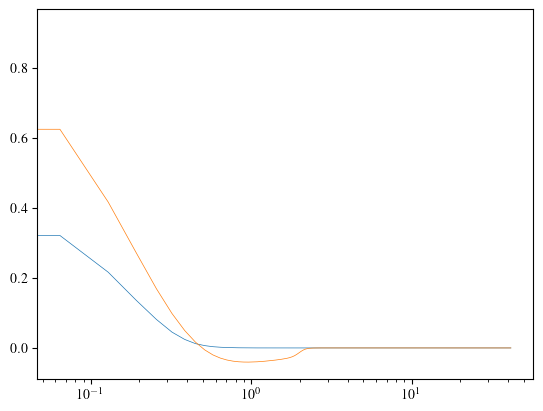

In [100]:
plt.plot(data3d.z, pISSImean, linewidth=0.5) # If not normed use factor 10**-2
plt.plot(data3d.z, pmean, linewidth=0.5)
plt.xscale("log")
#plt.yscale("log")

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7332/3326596410.py:5: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 3])


(0.04636992559043093, 3)

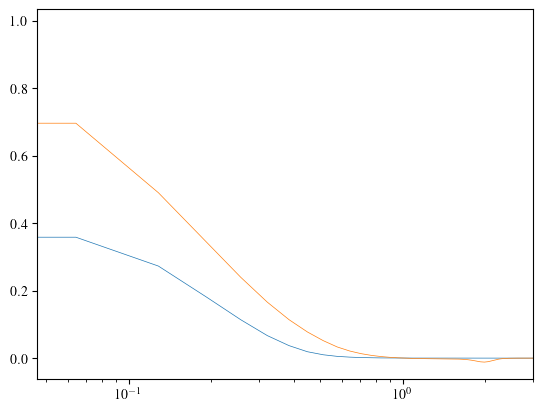

In [115]:
plt.plot(data3d.z, rISSImean, linewidth=0.5) # if not normed use factor *G_SOLAR*10**6
plt.plot(data3d.z, rmean, linewidth=0.5) # if not normed use factor *G_SOLAR
#plt.yscale("log")
plt.xscale("log")
plt.xlim([0, 3])
#plt.ylim([10**-8, 10**0])

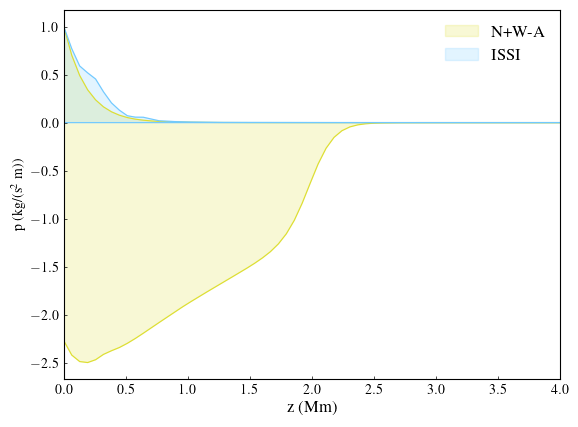

In [116]:
fig, ax1 = plt.subplots()


ax1.fill_between(z_arr, pmin, pmax, color= c8, alpha=0.2, label=r"N+W-A")

ax1.plot(
    z_arr,
    pmin,
    linewidth=0.8,
    color= c8,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    z_arr,
    pmax,
    linewidth=0.8,
    color=c8,
)

ax1.fill_between(z_arr, pISSImin, pISSImax, color= c1, alpha=0.2, label=r"ISSI")

ax1.plot(
    z_arr,
    pISSImin,
    linewidth=0.8,
    color= c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    z_arr,
    pISSImax,
    linewidth=0.8,
    color=c1,
)


plt.ylabel(r"p (kg/($\textrm{s}^2$ m))")
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
plt.xlim([0,4])
# plotname = folder + "/fpres_comp.png"
# plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

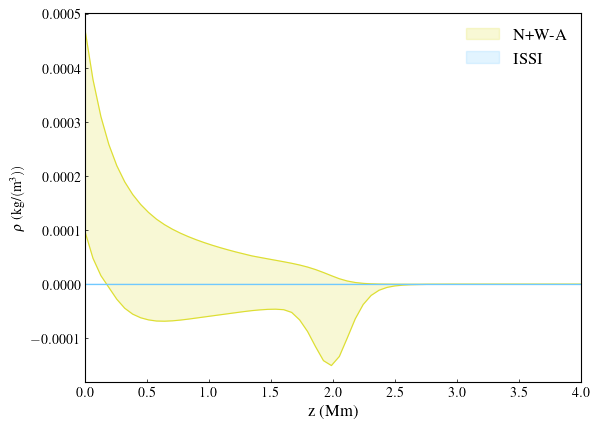

In [117]:
fig, ax1 = plt.subplots()


ax1.fill_between(z_arr, rmin, rmax, color= c8, alpha=0.2, label=r"N+W-A")

ax1.plot(
    z_arr,
    rmin,
    linewidth=0.8,
    color= c8,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    z_arr,
    rmax,
    linewidth=0.8,
    color=c8,
)

ax1.fill_between(z_arr, rISSImin, rISSImax, color= c1, alpha=0.2, label=r"ISSI")

ax1.plot(
    z_arr,
    rISSImin,
    linewidth=0.8,
    color= c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.plot(
    z_arr,
    rISSImax,
    linewidth=0.8,
    color=c1,
)

plt.ylabel(r"$\rho$ (kg/$(\textrm{m}^3))$")
ax1.set_xlabel(r"z (Mm)", fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.tick_params(direction="in", length=2, width=0.5)
plt.xlim([0,4])
# plotname = folder + "/fden_comp.png"
# plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [119]:
from mhsflex.metrics import pearson_corr_coeff_issi_2

In [121]:
pearson_corr_coeff_issi_2(fpresISSINormed, fdenISSINormed, data3d, fpresNormed, fdenNormed, heights, temps)

Pearson Correlation reference value for pressure  PearsonRResult(statistic=0.9999999999999943, pvalue=0.0)
Pearson Correlation reference value for density  PearsonRResult(statistic=0.9999999999999998, pvalue=0.0)
Pearson Correlation actual value for pressure  PearsonRResult(statistic=0.5157480357421567, pvalue=0.0)
Pearson Correlation actual value for density  PearsonRResult(statistic=0.4700152007545908, pvalue=0.0)


In [122]:
from mhsflex.metrics import field_div_metric_fb, field_div_metric_issi

In [123]:
field_div_metric_issi(B_ref, data3d)

/Users/lilli/Desktop/mflex/mhsflex/metrics.py:745: RuntimeWarning: invalid value encountered in scalar divide
  print(
/Users/lilli/Desktop/mflex/mhsflex/metrics.py:745: RuntimeWarning: divide by zero encountered in scalar divide
  print(


5202 4518 1507


0.3335546702080567